<a href="https://colab.research.google.com/github/ArtyomShabunin/SMOPA/blob/main/lesson_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://prana-system.com/files/110/rds_color_full.png" alt="tot image" width="300"  align="center"/> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src="https://mpei.ru/AboutUniverse/OficialInfo/Attributes/PublishingImages/logo1.jpg" alt="mpei image" width="200" align="center"/>
<img src="https://mpei.ru/Structure/Universe/tanpe/structure/tfhe/PublishingImages/tot.png" alt="tot image" width="100"  align="center"/>

---

# **Системы машинного обучения и предиктивной аналитики в тепловой и возобновляемой энергетике**  

# ***Практические занятия***


---

# Занятие №7
# Многоклассовая классификация методами глубокого обучения
**2 апреля 2025г.**

In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
# from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

from imblearn.under_sampling import RandomUnderSampler

from tqdm import tqdm

In [101]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
device

device(type='cuda')

## Загрузка данных

In [102]:
import gdown
import warnings
warnings.filterwarnings('ignore')
gdown.download('https://drive.google.com/uc?id=1j54o4pHTm3HvaYTEtv_i4hOJGy5yNeZZ', verify=False)

data = pd.read_parquet("./data_modes.gzip")

Downloading...
From (original): https://drive.google.com/uc?id=1j54o4pHTm3HvaYTEtv_i4hOJGy5yNeZZ
From (redirected): https://drive.google.com/uc?id=1j54o4pHTm3HvaYTEtv_i4hOJGy5yNeZZ&confirm=t&uuid=417f452a-16f0-4d74-9731-f2511224fb51
To: /content/data_modes.gzip
100%|██████████| 173M/173M [00:01<00:00, 118MB/s]


In [103]:
data.shape

(1082098, 56)

In [104]:
data.head()

,GTA1.DBinPU.Aldi,GTA1.DBinPU.Alvna,GTA1.DBinPU.Alzzo,GTA1.DBinPU.Bo,GTA1.DBinPU.DlPkf,GTA1.DBinPU.DlPtgft,GTA1.DBinPU.DlPvf,GTA1.DBinPU.fi,GTA1.DBinPU.hmGTD,GTA1.DBinPU.hmTG,...,heated_air,zzo_is_open,full_power_mode,partial_power_mode,increas_power_mode,decreas_power_mode,start_up_mode,shutdown_mode,stopped_state_mode,air_heating_mode
2023-02-26 06:59:50,225.550000,-4.398000,-0.082000,101.044,113.088000,33.709000,0.200000,56.615000,442.64,444.536,...,False,False,True,False,False,False,False,False,False,False
2023-02-26 07:00:00,225.610769,-4.327115,-0.089769,101.044,113.151231,33.709000,0.200000,56.615000,442.64,444.536,...,False,False,True,False,False,False,False,False,False,False
2023-02-26 07:00:10,225.436897,-4.363724,-0.091000,101.044,113.039759,33.633586,0.200207,56.516103,442.64,444.536,...,False,False,True,False,False,False,False,False,False,False
2023-02-26 07:00:20,225.710833,-4.306625,-0.093000,101.044,113.053458,33.506500,0.200750,56.376000,442.64,444.536,...,False,False,True,False,False,False,False,False,False,False
2023-02-26 07:00:30,226.355000,-4.183118,-0.091500,101.044,113.730941,33.818529,0.200000,56.199353,442.64,444.536,...,False,False,True,False,False,False,False,False,False,False


## Сформируем датасет для решения задачи многоклассовой классификации

Выберем сигналы которые будем использовать. Исключим все признаки на основании которых выделялись целевые режимы.

In [105]:
feature_columns = [
    'GTA1.DBinPU.Alzzo', 'GTA1.DBinPU.Bo', 'GTA1.DBinPU.DlPkf',
    'GTA1.DBinPU.DlPtgft', 'GTA1.DBinPU.DlPvf', 'GTA1.DBinPU.fi',
    'GTA1.DBinPU.hmGTD', 'GTA1.DBinPU.hmTG', 'GTA1.DBinPU.P1mvhTG',
    'GTA1.DBinPU.Pk',
    'GTA1.DBinPU.Pmvh', 'GTA1.DBinPU.PmvhMOGTD',
    'GTA1.DBinPU.PmvhMOTG', 'GTA1.DBinPU.PmvyhMOGTD',
    'GTA1.DBinPU.PmvyhMOTG', 'GTA1.DBinPU.Prazrjag_navhode',
    'GTA1.DBinPU.Ptgpd', 'GTA1.DBinPU.Ptgvh',
    'GTA1.DBinPU.Pvh',
    'GTA1.DBinPU.Pvyhlg',
    'GTA1.DBinPU.Qtg', 'GTA1.DBinPU.Tk',
    'GTA1.DBinPU.Tn', 'GTA1.DBinPU.Tt', 'GTA1.DBinPU.Tvh1',
    'GTA1.DBinPU.Pzad']

target_columns = [
    'full_power_mode',
    'partial_power_mode',
    # 'increas_power_mode',
    # 'decreas_power_mode',
    # 'start_up_mode',
    # 'shutdown_mode',
    'stopped_state_mode'
]

In [106]:
# data.loc[data['adjustment_range'], ['start_up_mode']] = False
# data.loc[data['adjustment_range'], ['shutdown_mode']] = False
# data.loc[data['increase_power'], ['shutdown_mode']] = False
# data.loc[data['decreas_power_mode'], ['start_up_mode']] = False

In [107]:
# data = data.loc[data[target_columns].sum(axis=1) == 1]

In [108]:
X = data.loc[:,feature_columns]

In [109]:
data['target'] = data[target_columns].idxmax(axis=1)
y = data.loc[:, ['target']]

In [110]:
y.value_counts()

,count
target,
full_power_mode,1045781
stopped_state_mode,26770
partial_power_mode,9547


### Деление на тестовую и тренировочную выборки

In [111]:
from sklearn.model_selection import train_test_split
# Разделяем с учетом дисбаланса классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [112]:
y_train.value_counts()

,count
target,
full_power_mode,836624
stopped_state_mode,21416
partial_power_mode,7638


In [113]:
y_test.value_counts()

,count
target,
full_power_mode,209157
stopped_state_mode,5354
partial_power_mode,1909


Видно, что датасет сильно несбалансирован.
При такой несбалансорованности модели будут плохо обучаеться на редких классах.
Алгоритм может игнорировать малочисленные классы, потому что минимизация ошибки будет достигаться за счет предсказания большинства.
Например, если модель всегда предсказывает full_power_mode, она все равно получит высокую точность.

### Балансировка данных
**Oversampling (увеличение малых классов)**  
   - Повторение существующих редких примеров или их генерация.  
   - **SMOTE (Synthetic Minority Over-sampling Technique)** – создает новые точки малочисленных классов, используя линейные комбинации соседних точек.  

**Undersampling (уменьшение частых классов)**  
- Удаление случайных примеров из большинства классов.  

**Комбинация Oversampling + Undersampling**  
   - Часто лучше сначала **уменьшить большие**, а затем **увеличить малые классы**.  

#### Undersampling

In [114]:
from imblearn.under_sampling import RandomUnderSampler
sampling_strategy = {
    "full_power_mode": 1000,
    "stopped_state_mode": 1000,
    "partial_power_mode": 1000
}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [115]:
y_train_resampled.value_counts()

,count
target,
full_power_mode,1000
partial_power_mode,1000
stopped_state_mode,1000


In [116]:
sampling_strategy = {
    "full_power_mode": 100,
    "stopped_state_mode": 100,
    "partial_power_mode": 100
}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_test_resampled, y_test_resampled = rus.fit_resample(X_test, y_test)

In [117]:
y_test_resampled.value_counts()

,count
target,
full_power_mode,100
partial_power_mode,100
stopped_state_mode,100


#### Oversampling

In [118]:
from imblearn.over_sampling import SMOTE
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train_resampled, y_train_resampled)

In [119]:
y_train_resampled.value_counts()

,count
target,
full_power_mode,1000
partial_power_mode,1000
stopped_state_mode,1000


### Нормализация или стандартизация данных

In [120]:
# scaler = preprocessing.MinMaxScaler() # нормализация данных
scaler = preprocessing.StandardScaler() # стандартизация данных

X_train_resampled_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_resampled),
    columns=X_train_resampled.columns,
    index=X_train_resampled.index)

X_test_resampled_scaled = pd.DataFrame(
    scaler.transform(X_test_resampled),
    columns=X_test_resampled.columns,
    index=X_test_resampled.index)

X_train_resampled_scaled.describe()

,GTA1.DBinPU.Alzzo,GTA1.DBinPU.Bo,GTA1.DBinPU.DlPkf,GTA1.DBinPU.DlPtgft,GTA1.DBinPU.DlPvf,GTA1.DBinPU.fi,GTA1.DBinPU.hmGTD,GTA1.DBinPU.hmTG,GTA1.DBinPU.P1mvhTG,GTA1.DBinPU.Pk,...,GTA1.DBinPU.Ptgpd,GTA1.DBinPU.Ptgvh,GTA1.DBinPU.Pvh,GTA1.DBinPU.Pvyhlg,GTA1.DBinPU.Qtg,GTA1.DBinPU.Tk,GTA1.DBinPU.Tn,GTA1.DBinPU.Tt,GTA1.DBinPU.Tvh1,GTA1.DBinPU.Pzad
count,3.000000e+03,3.000000e+03,3000.000000,3000.000000,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,...,3000.000000,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03
mean,-9.473903e-18,1.222607e-14,0.000000,0.000000,2.273737e-16,2.652693e-16,-1.215028e-15,-9.829175e-16,1.136868e-16,-7.579123e-17,...,0.000000,2.273737e-16,1.743198e-15,-1.136868e-16,-1.515825e-16,-2.273737e-16,-7.579123e-17,1.515825e-16,-1.894781e-17,-1.515825e-16
std,1.000167e+00,1.000167e+00,1.000167,1.000167,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,...,1.000167,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00
min,-2.076325e-01,-3.600363e+00,-1.319045,-1.266297,-1.366010e+00,-2.238373e+00,-1.422283e+00,-1.677930e+00,-1.623786e+00,-1.378703e+00,...,-1.414613,-1.419812e+00,-1.749094e+00,-1.138379e+00,-1.360400e+00,-1.424960e+00,-2.622070e+00,-1.426861e+00,-2.950839e+00,-1.319213e+00
25%,-2.014321e-01,-7.036436e-01,-1.295837,-1.258417,-1.332026e+00,-7.608600e-01,-1.048513e+00,-8.612304e-01,-1.574989e+00,-1.372347e+00,...,-1.412181,-1.417475e+00,-8.524652e-01,-1.105616e+00,-1.360340e+00,-1.381507e+00,-7.888381e-01,-1.399296e+00,-6.591286e-01,-1.319213e+00
50%,-1.975053e-01,2.538132e-01,0.178991,0.063523,2.025547e-01,-1.329417e-01,-1.541689e-01,-2.232318e-02,6.005737e-01,4.231707e-01,...,0.654772,6.760768e-01,-5.306281e-01,-3.902388e-02,4.799045e-01,5.202733e-01,-1.342659e-01,5.761435e-01,-2.374390e-02,2.383969e-01
75%,-1.944335e-01,7.154589e-01,0.827057,0.872796,8.441639e-01,6.642379e-01,5.607690e-01,3.886341e-01,6.674253e-01,8.712557e-01,...,0.702143,7.053729e-01,1.204427e+00,1.193026e+00,8.075137e-01,7.971948e-01,9.998610e-01,7.854134e-01,9.056631e-01,9.587912e-01
max,5.230260e+00,2.946557e+00,1.523526,7.114079,1.344066e+00,2.647111e+00,2.511558e+00,2.231608e+00,9.836127e-01,9.538813e-01,...,0.957880,9.101548e-01,1.453663e+00,1.512869e+00,1.307180e+00,1.074492e+00,2.091435e+00,1.005543e+00,2.066186e+00,9.587912e-01


### Encoding

In [121]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [122]:
y_train_resampled_encoded = encoder.fit_transform(y_train_resampled.values[:,0])
y_test_resampled_encoded = encoder.transform(y_test_resampled.values[:,0])

In [123]:
y_train_resampled.head()

,target
0,full_power_mode
1,full_power_mode
2,full_power_mode
3,full_power_mode
4,full_power_mode


## Полносвязная нейронная сеть (многослойный персептрон)

Инициализируем переменные для дальнейшего сравнения моделей

In [124]:
accuracy_classifier = {}
precision_classifier = {}
recall_classifier = {}
f1_classifier = {}

### Dataset

In [125]:
class ModeDataset(Dataset):
    def __init__(self):
        self.x = torch.tensor(X_train_resampled.values, dtype=torch.float32)
        self.y = torch.tensor(y_train_resampled_encoded,dtype=torch.long)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.x.shape[0]

In [126]:
dataset = ModeDataset()

print(len(dataset))
print("Sample number 0 : ", dataset[0])
print(dataset[0][0], dataset[0][1])

3000
Sample number 0 :  (tensor([-4.5133e-02,  1.0029e+02,  1.2939e+02,  3.9102e+01,  2.0000e-01,
         5.0533e+01,  4.2704e+02,  4.3021e+02,  4.3847e+01,  8.1500e-01,
         3.2700e-01, -4.3000e-03,  1.2900e-01,  0.0000e+00,  0.0000e+00,
         5.4200e-01,  1.7960e+00,  1.8940e+00,  9.0917e+01,  6.6933e-01,
         2.0160e+03,  2.8210e+02, -2.7118e+00,  4.4460e+02, -3.4362e+00,
         5.8500e+03]), tensor(0))
tensor([-4.5133e-02,  1.0029e+02,  1.2939e+02,  3.9102e+01,  2.0000e-01,
         5.0533e+01,  4.2704e+02,  4.3021e+02,  4.3847e+01,  8.1500e-01,
         3.2700e-01, -4.3000e-03,  1.2900e-01,  0.0000e+00,  0.0000e+00,
         5.4200e-01,  1.7960e+00,  1.8940e+00,  9.0917e+01,  6.6933e-01,
         2.0160e+03,  2.8210e+02, -2.7118e+00,  4.4460e+02, -3.4362e+00,
         5.8500e+03]) tensor(0)


In [151]:
BATCH_SIZE = 1026

INPUT_SIZE = len(feature_columns)
OUTPUT_SIZE = len(target_columns)

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Функция для обучения модели

In [152]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):

    loaders = {"train": train_loader, "valid": valid_loader}

    epochs = num_epochs

    lr = []
    losses = {"train": [], "valid": []}
    for epoch in tqdm(range(epochs)):

        for k, dataloader in loaders.items():
            running_loss = []

            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                loss = criterion(outp, y_batch)
                running_loss.append(loss.item())

                if k == "train":

                    loss.backward()
                    optimizer.step()

            if k == "train":
                lr.append(scheduler.optimizer.param_groups[0]['lr'])
            losses[k].append(np.array(running_loss).mean())

        scheduler.step(losses["train"][-1])

    return model, losses, lr

### Архитектура нейронной сети

In [254]:
class FCNN(nn.Module):
  def __init__(self, hidden_size=512, hidden_num=1):
    super(FCNN, self).__init__()
    self.hidden_num = hidden_num
    self.linear = nn.ModuleList()
    self.batchnorm = nn.ModuleList()
    self.dropout = nn.ModuleList()
    for i in range(self.hidden_num):
      if i == 0:
        self.linear.append(nn.Linear(INPUT_SIZE, hidden_size))
      else:
        self.linear.append(nn.Linear(hidden_size, hidden_size))

      self.batchnorm.append(nn.BatchNorm1d(hidden_size))
      self.dropout.append(nn.Dropout(0.5))
      self.out = nn.Linear(hidden_size, OUTPUT_SIZE)

  def forward(self, x):
    for i in range(self.hidden_num):
        x = self.linear[i](x)
        # x = self.batchnorm[i](x)

        x = F.relu(x)
        # if (i != self.hidden_num - 1) and (i != 0):
        #   x = self.dropout[i](x)

    result = self.out(x)
    return result
    # return F.log_softmax(result, dim=1)


  def _initialize_weights(self):
    for layer in self.linear:
      nn.init.xavier_uniform_(layer.weight)  # Xavier для скрытых слоев
      if layer.bias is not None:
        nn.init.zeros_(layer.bias)  # Обнуляем bias

      nn.init.xavier_uniform_(self.out.weight)  # Xavier для выходного слоя
      if self.out.bias is not None:
        nn.init.zeros_(self.out.bias)  # Обнуляем bias

### Обучение модели

In [286]:
FCNN_64_2 = FCNN(16, 5).to(device)
FCNN_64_2._initialize_weights()

# criterion = nn.MSELoss()

class_weights = torch.tensor([2.0, 2.0, 1.0]).to(device)

criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(FCNN_64_2.parameters(), lr=1e-3)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=60, threshold=0.0001)

FCNN_64_2, losses_FCNN_64_2, lr_FCNN_64_2 = train_model(
    FCNN_64_2, criterion, optimizer,
    scheduler, num_epochs=3000)

100%|██████████| 3000/3000 [01:34<00:00, 31.91it/s]


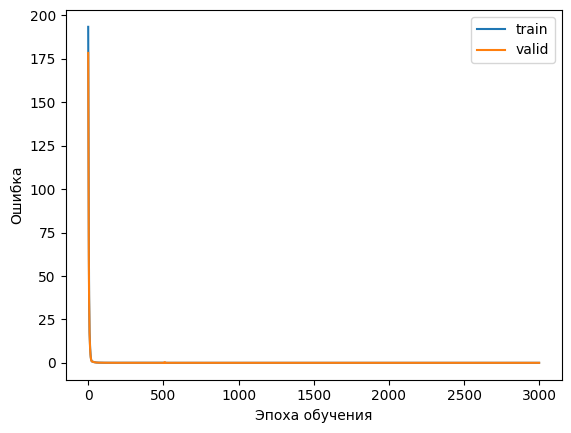

In [287]:
plt.plot(losses_FCNN_64_2['train'], label='train');
plt.plot(losses_FCNN_64_2['valid'], label='valid');
plt.legend();
plt.ylabel("Ошибка");
plt.xlabel("Эпоха обучения");

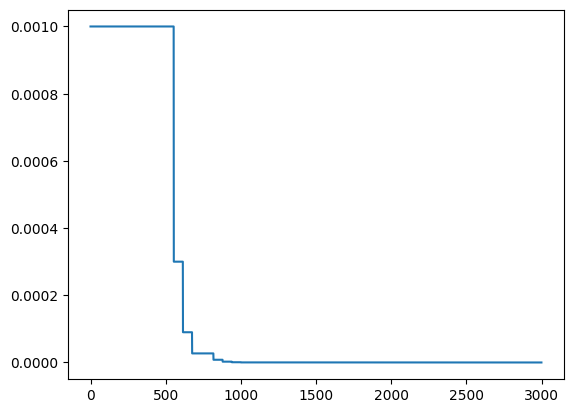

In [288]:
plt.plot(lr_FCNN_64_2);

In [289]:
print('Loss в конце обучения')
print(f'На обучающей выборке: {losses_FCNN_64_2["train"][-1]:.5f}')
print(f'На валидационной выборке: {losses_FCNN_64_2["valid"][-1]:.5f}')

Loss в конце обучения
На обучающей выборке: 0.02540
На валидационной выборке: 0.03065


In [290]:
some_indexes = y_test_resampled.groupby('target').sample(n=1, random_state=42).index
X_some_modes = X_test_resampled_scaled.loc[some_indexes]
y_some_modes = y_test_resampled.loc[some_indexes]

FCNN_64_2.to("cpu")
FCNN_64_2.eval()
logits = FCNN_64_2(torch.tensor(X_some_modes.values, dtype=torch.float32))
predicted_classes = torch.argmax(logits, dim=1)

for target, predict in zip(y_some_modes.values, predicted_classes.detach().numpy()):
    print(f"Истина - {target[0]} >>> {encoder.inverse_transform([predict])[0]} - предсказание")

Истина - full_power_mode >>> partial_power_mode - предсказание
Истина - partial_power_mode >>> full_power_mode - предсказание
Истина - stopped_state_mode >>> full_power_mode - предсказание


In [281]:
logits

tensor([[-0.0070, -0.0017, -0.0151],
        [-0.0344,  0.0003, -0.0297],
        [-0.1115, -0.0530, -0.0361]], grad_fn=<AddmmBackward0>)

In [282]:
torch.softmax(logits, dim=1)

tensor([[0.3336, 0.3354, 0.3310],
        [0.3289, 0.3406, 0.3305],
        [0.3186, 0.3378, 0.3436]], grad_fn=<SoftmaxBackward0>)

### Анализ качества модели

In [291]:
FCNN_64_2.eval()
logits =  FCNN_64_2(torch.tensor(X_test_resampled_scaled.values, dtype=torch.float32))

probabilities = torch.softmax(logits, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1)

y_test_pred_FCNN_64_2 = encoder.inverse_transform(predicted_classes)

#### Матрица неточностей

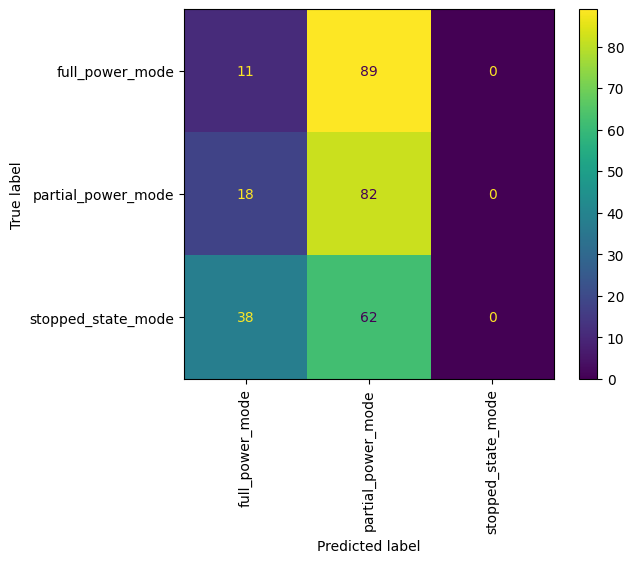

In [292]:
conf_mat = confusion_matrix(y_test_resampled, y_test_pred_FCNN_64_2)
ConfusionMatrixDisplay(conf_mat, display_labels=encoder.classes_).plot()
plt.xticks(rotation=90)
plt.show()

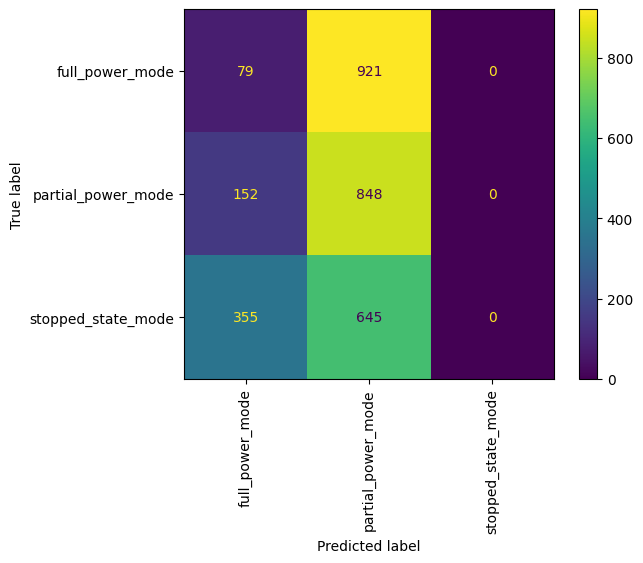

In [293]:
FCNN_64_2.to("cpu")
FCNN_64_2.eval()
logits =  FCNN_64_2(torch.tensor(X_train_resampled_scaled.values, dtype=torch.float32))

probabilities = torch.softmax(logits, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1)

y_train_pred_FCNN_64_2 = encoder.inverse_transform(predicted_classes)

conf_mat = confusion_matrix(y_train_resampled, y_train_pred_FCNN_64_2)
ConfusionMatrixDisplay(conf_mat, display_labels=encoder.classes_).plot()
plt.xticks(rotation=90)
plt.show()

In [ ]:
FCNN_64_5 = FCNN(26, 7, 64, 5)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(FCNN_64_5.parameters(), lr=1e-3)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=3, threshold=0.0001)

FCNN_64_5, losses_FCNN_64_5 = train_model(
    FCNN_64_5, criterion, optimizer,
    scheduler, num_epochs=100)

100%|██████████| 100/100 [00:12<00:00,  7.72it/s]


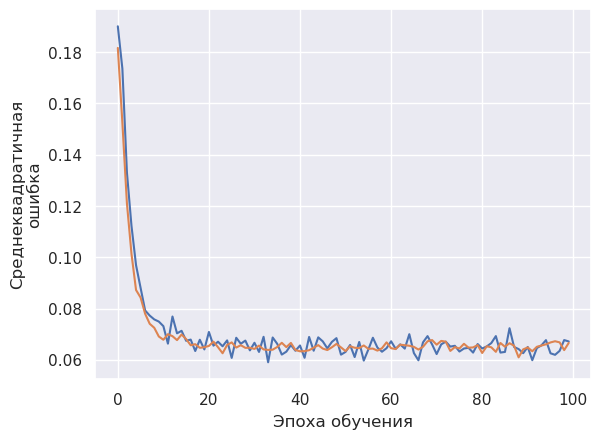

In [ ]:
plt.plot(losses_FCNN_64_5['train'], label='train');
plt.plot(losses_FCNN_64_5['valid'], label='valid');
plt.ylabel("Среднеквадратичная\nошибка");
plt.xlabel("Эпоха обучения");

In [ ]:
FCNN_256_2 = FCNN(26, 7, 256, 2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(FCNN_256_2.parameters(), lr=1e-3)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=3, threshold=0.0001)

FCNN_256_2, losses_FCNN_256_2 = train_model(
    FCNN_256_2, criterion, optimizer,
    scheduler, num_epochs=100)

100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


In [ ]:
plt.plot(losses_FCNN_256_2['train'], label='train');
plt.plot(losses_FCNN_256_2['valid'], label='valid');
plt.ylabel("Среднеквадратичная\nошибка");
plt.xlabel("Эпоха обучения");
plt.legend();

NameError: name 'losses_FCNN_256_2' is not defined

In [ ]:
# y_test_pred = cross_val_predict(FCNN_256_2, torch.tensor(X_test, dtype=torch.float32), y_test, cv=3)
# conf_mx = confusion_matrix(y_test, y_train_pred)
# conf_mx

array([[-0.21138504,  0.55662423, -0.35919895, ...,  0.38173824,
         0.92805023, -0.39852083],
       [-0.21380329, -0.50087478,  0.92281509, ...,  0.75502602,
         1.03233705,  0.97874579],
       [ 1.91535401,  0.55583456,  0.84823309, ...,  0.50466226,
        -1.60257995,  0.97874579],
       ...,
       [-0.2194112 ,  0.409426  ,  0.11006636, ...,  0.24972722,
        -1.21506219,  0.15773938],
       [-0.21823864,  1.35595022,  0.61681358, ...,  0.41620173,
        -0.71802525,  0.69028408],
       [-0.2203578 ,  0.5435486 ,  0.5195617 , ...,  0.46310713,
        -0.98825485,  0.97874579]])

In [ ]:
y_train_pred = FCNN_256_2(torch.tensor(scaler.transform(X_test), dtype=torch.float32)).detach().numpy()

In [ ]:
y_test = torch.tensor(y_test, dtype=torch.float32).detach().numpy()

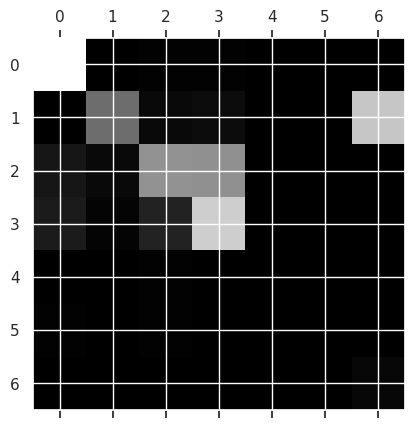

In [ ]:
conf_mx = confusion_matrix(y_test.argmax(axis=1), y_train_pred.argmax(axis=1))
conf_mx
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
!pip install shap

import shap

explainer = shap.Explainer(lambda x: FCNN_64_2(torch.tensor(x.values, dtype=torch.float32)), X_train_resampled_scaled)
shap_values = explainer(X_test_resampled_scaled)

shap.summary_plot(shap_values, X_test_resampled_scaled, class_names=target_columns)